In [1]:
import numpy as np 
import os
import scipy.io
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset 
from torchinfo import summary

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

from imblearn.over_sampling import SMOTE

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SAMPLE_LENGTH = 1024

SENSOR = 'all'
LOAD_LEVELS = [0,1]
FAULT_TYPE = list(range(10))
NUM_CLASSES = len(FAULT_TYPE)

SIZE_INPUT = int(SAMPLE_LENGTH**(1/2))
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 0.001

NORMAL_SAMPLES_USED = 500
CLASS_RATIOS = {0: 25, 
        1: 1,
        2: 1,
        3: 1,
        4: 1,
        5: 1,
        6: 1,
        7: 1,
        8: 1,
        9: 1}

# DATA HANDLING
def import_file(bearing = 'DE', fault_type = 0, load_level = 0, sensor = 'all', print_infor = False, sample_length = 1024, base_path = 'CWRU-dataset-main'):
    """
    Import data 

    Args:
        bearing (str): 'DE' or 'FE'
        fault_type (int): label from 0 to 9 
        load_level (int): 0 HP, 1 HP, 2 HP
        sensor (str) : 'DE', 'FE', 'BA', 'all'
        base_path (str): Base path to dataset

        output: data (numpy array)
    """
    if bearing == 'DE': 
        base_data_directory = os.path.join(base_path, '12k_Drive_End_Bearing_Fault_Data/')
    else: 
        base_data_directory = os.path.join(base_path, '12k_Fan_End_Bearing_Fault_Data/')

    fault_dict = {
        0 : 'Normal/',
        1 : 'B/007/',
        2 : 'B/014/',
        3 : 'B/021/',
        4 : 'IR/007/',
        5 : 'IR/014/',
        6 : 'IR/021/',
        7 : 'OR/007/@6/',
        8 : 'OR/014/',
        9 : 'OR/021/@6/'
    }
    load_level_dict = {
        0 : '_0',
        1 : '_1',
        2 : '_2',
    }

    file_path = os.path.join(base_data_directory, fault_dict[fault_type])
    full_file_path = None

    try:
        file_list = os.listdir(file_path)
        for file in file_list: 
            full_path = os.path.join(file_path, file)
            if os.path.isfile(full_path): 
                if load_level_dict[load_level] in file: 
                    full_file_path = full_path

            if full_file_path:
                break
    except Exception as e: 
        print(f'File path not exists: {e}')
        return np.array([])

    if full_file_path is None:
        print(f'No file found for bearing={bearing}, fault_type={fault_type}, load_level={load_level}')
        return np.array([])

    data = np.array([])
    data_import = None
    mat_data = scipy.io.loadmat(full_file_path)
    keys_in_file = list(mat_data.keys())

    for key in keys_in_file: 
        if sensor == 'all' and ('DE' in key or 'FE' in key or 'BA' in key):
            data_import = mat_data[key].flatten()
            length = (len(data_import) // sample_length) * sample_length
            data_import = data_import[:length]
            data = np.append(data, data_import)
            if print_infor: 
                print('================= Import data =====================')
                print(f' - Process file: {full_file_path}')
                print(f' - Key: {key}')
                print(f' - Data length: {len(data)/sample_length}')
                print('===================================================')
        elif sensor in key:
            data = mat_data[key].flatten()
            length = (len(data)//sample_length) * sample_length
            data = data[:length]
            if print_infor: 
                print('================= Import data =====================')
                print(f' - Process file: {full_file_path}')
                print(f' - Key: {key}')
                print(f' - Data length: {len(data)/sample_length}')
                print('===================================================')
            break

    return data

def import_data(bearing = 'DE', load_level = list(range(3)), fault_type=list(range(10)), sensor = 'all', sample_length = 1024, base_path = 'CWRU-dataset-main'):
    """Enhanced import_data with better structure"""
    X_data = []
    Y_data = []

    for load in load_level: 
        for fault_type_label in fault_type:
            data = import_file(bearing, fault_type_label, load, sensor, False, sample_length, base_path)
            if len(data) > 0:
                data_reshaped = data.reshape(-1, sample_length)
                labels = np.full(data_reshaped.shape[0], fault_type_label)
                X_data.append(data_reshaped)
                Y_data.append(labels)

    if not X_data:
        raise ValueError("No data was loaded. Please check your parameters and file paths.")
    
    final_X_data = np.concatenate(X_data, axis=0)
    final_Y_data = np.concatenate(Y_data, axis=0)

    final_X_data = np.reshape(final_X_data, (-1, 1, SIZE_INPUT, SIZE_INPUT))
    
    print('Original data shape:', final_X_data.shape)
    print('Original labels shape:', final_Y_data.shape)

    return final_X_data, final_Y_data

def create_imbalanced_split(X_data, Y_data, normal_samples=None, class_ratios=None, test_size=0.3, random_state=42):
    """
    Create train/test split for imbalanced data
    
    Args:
        X_data: Input features
        Y_data: Labels
        normal_samples: Number of normal class samples to use (None = use all)
        class_ratios: Dictionary defining ratio between classes 
                     e.g., {0: 4, 4: 1, 1: 2, 7: 1} means normal:IR007:B007:OR007 = 4:1:2:1
        test_size: Proportion for test set (default 0.3)
        random_state: Random seed
    
    Returns:
        X_train, X_test, y_train, y_test
    """
    
    # Get class distribution
    unique_classes, class_counts = np.unique(Y_data, return_counts=True)

    # Step 1: Create balanced test set
    min_class_samples = min(class_counts)
    test_samples_per_class = int(min_class_samples * test_size)
    
    X_test_list = []
    y_test_list = []
    X_train_temp_list = []
    y_train_temp_list = []
    
    # Split each class separately to ensure balanced test set
    for cls in unique_classes:
        cls_indices = np.where(Y_data == cls)[0]
        X_cls = X_data[cls_indices]
        y_cls = Y_data[cls_indices]
        
        # Random split for this class
        X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(
            X_cls, y_cls, test_size=test_samples_per_class, 
            random_state=random_state, stratify=None
        )
        
        X_test_list.append(X_cls_test)
        y_test_list.append(y_cls_test)
        X_train_temp_list.append(X_cls_train)
        y_train_temp_list.append(y_cls_train)
    
    # Combine test data
    X_test = np.concatenate(X_test_list, axis=0)
    y_test = np.concatenate(y_test_list, axis=0)
    
    # Combine remaining training data
    X_train_temp = np.concatenate(X_train_temp_list, axis=0)
    y_train_temp = np.concatenate(y_train_temp_list, axis=0)
    
    # Step 2: Create imbalanced training set based on user specifications
    if class_ratios is None:
        # If no ratios specified, use all remaining training data
        X_train = X_train_temp
        y_train = y_train_temp
    else:
        # Apply class ratios to create imbalanced training set
        X_train_list = []
        y_train_list = []
        
        # Determine number of samples for each class based on ratios
        normal_class = 0  # Assuming class 0 is normal
        
        if normal_samples is None:
            # Use all available normal samples
            normal_indices = np.where(y_train_temp == normal_class)[0]
            normal_samples = len(normal_indices)
        
        # Calculate samples for each class based on ratios
        normal_ratio = class_ratios.get(normal_class, 1)
        
        # First pass: determine actual normal samples to use as base
        normal_indices = np.where(y_train_temp == normal_class)[0]
        available_normal = len(normal_indices)
        actual_normal_samples = min(normal_samples, available_normal)
        
        for cls in unique_classes:
            cls_indices = np.where(y_train_temp == cls)[0]
            available_samples = len(cls_indices)
            
            if cls == normal_class:
                # Use the determined number of normal samples
                target_samples = actual_normal_samples
            else:
                # Calculate based on ratio to normal class
                cls_ratio = class_ratios.get(cls, 0)  # Default to 0 if class not in ratios
                if cls_ratio > 0:
                    target_samples = int((actual_normal_samples * cls_ratio) / normal_ratio)
                    target_samples = min(target_samples, available_samples)
                else:
                    target_samples = 0  # Skip classes not in ratios
            
            # Randomly sample the target number
            if target_samples > 0:
                selected_indices = np.random.choice(cls_indices, target_samples, replace=False)
                X_train_list.append(X_train_temp[selected_indices])
                y_train_list.append(y_train_temp[selected_indices])
        
        X_train = np.concatenate(X_train_list, axis=0)
        y_train = np.concatenate(y_train_list, axis=0)
    
    # Shuffle training data
    train_indices = np.random.permutation(len(X_train))
    X_train = X_train[train_indices]
    y_train = y_train[train_indices]
    
    # Shuffle test data
    test_indices = np.random.permutation(len(X_test))
    X_test = X_test[test_indices]
    y_test = y_test[test_indices]
    
    # Print final distribution
    print('='*50)
    print(f"Final split results:")
    print(f"Test set - Total samples: {len(y_test)}")
    test_unique, test_counts = np.unique(y_test, return_counts=True)
    for cls, count in zip(test_unique, test_counts):
        print(f"  Class {cls}: {count} samples")
    
    print(f"\nTrain set - Total samples: {len(y_train)}")
    train_unique, train_counts = np.unique(y_train, return_counts=True)
    for cls, count in zip(train_unique, train_counts):
        print(f"  Class {cls}: {count} samples")
    
    return X_train, X_test, y_train, y_test

def analyze_class_distribution(y_data, title="Class Distribution"):
    """Analyze and visualize class distribution"""
    unique_classes, counts = np.unique(y_data, return_counts=True)
    
    print('='*50)
    print(f"{title}:")
    for cls, count in zip(unique_classes, counts):
        percentage = (count / len(y_data)) * 100
        print(f"Class {cls}: {count} samples ({percentage:.2f}%)")
    
    return dict(zip(unique_classes, counts))

# Load data
X_data, Y_data = import_data(load_level=LOAD_LEVELS, fault_type=FAULT_TYPE, sensor=SENSOR, sample_length=SAMPLE_LENGTH)

# Analyze original distribution
analyze_class_distribution(Y_data, "Original Data Distribution")

# Create_imbalanced_split
X_train, X_test, y_train, y_test = create_imbalanced_split(
    X_data, Y_data, 
    normal_samples=NORMAL_SAMPLES_USED,  # Use only 500 normal samples
    class_ratios=CLASS_RATIOS
)

class BearingDataset(Dataset): 
    def __init__(self, X_data, Y_data, is_train = True):
        self.data = torch.from_numpy(X_data).float()

        self.labels = torch.from_numpy(Y_data).long()
        self.is_train = is_train

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


val_dataset = BearingDataset(X_test, y_test, False)
val_loader = DataLoader(val_dataset, batch_size= BATCH_SIZE, shuffle=False, num_workers= 0)

Original data shape: (7822, 1, 32, 32)
Original labels shape: (7822,)
Original Data Distribution:
Class 0: 1420 samples (18.15%)
Class 1: 711 samples (9.09%)
Class 2: 711 samples (9.09%)
Class 3: 711 samples (9.09%)
Class 4: 711 samples (9.09%)
Class 5: 708 samples (9.05%)
Class 6: 711 samples (9.09%)
Class 7: 714 samples (9.13%)
Class 8: 711 samples (9.09%)
Class 9: 714 samples (9.13%)
Final split results:
Test set - Total samples: 2120
  Class 0: 212 samples
  Class 1: 212 samples
  Class 2: 212 samples
  Class 3: 212 samples
  Class 4: 212 samples
  Class 5: 212 samples
  Class 6: 212 samples
  Class 7: 212 samples
  Class 8: 212 samples
  Class 9: 212 samples

Train set - Total samples: 680
  Class 0: 500 samples
  Class 1: 20 samples
  Class 2: 20 samples
  Class 3: 20 samples
  Class 4: 20 samples
  Class 5: 20 samples
  Class 6: 20 samples
  Class 7: 20 samples
  Class 8: 20 samples
  Class 9: 20 samples


In [2]:
# Reshape X_train for SMOTE
# Original shape: (n_samples, channels, height, width) e.g. (N, 1, 32, 32)
n_samples_train, channels, height, width = X_train.shape
X_train_reshaped = X_train.reshape(n_samples_train, channels * height * width) # (N, 1024)

# Initialize SMOTE
# Option 1: Balance all classes relative to the majority
# smote = SMOTE(random_state=42) # Default is 'auto' which is equivalent to 'not majority'
                                # or use sampling_strategy='all' to make all classes have same count as majority

# Option 2: Specify desired number of samples per class (RECOMMENDED for control)
# First, find out the current counts
train_counts_before_smote = Counter(y_train)
print(f"Counts before SMOTE: {train_counts_before_smote}")

# Example: Upsample all minority classes (1-9) to be, say, 80% of the normal class (0)
# or a fixed number like 500 samples each if available after create_imbalanced_split
# This needs careful thought based on your goals and initial counts from create_imbalanced_split

# Let's assume class 0 is the majority after create_imbalanced_split
# and we want to upsample classes 1-9.
# A common strategy is 'not majority' which upsamples all minority classes to match the majority.
# Or, if you want finer control:
# target_samples_minority = int(train_counts_before_smote[0] * 0.8) # e.g., 80% of normal class
# sampling_strategy_custom = {cls: max(count, target_samples_minority) for cls, count in train_counts_before_smote.items()}
# for cls in range(NUM_CLASSES): # Ensure all classes are in the strategy
#    if cls not in sampling_strategy_custom:
#        sampling_strategy_custom[cls] = train_counts_before_smote.get(cls, 0) # Keep original count if not specified or 0
#    if cls != 0 and cls in train_counts_before_smote: # For minority classes
#        sampling_strategy_custom[cls] = max(train_counts_before_smote[cls], target_samples_minority)
#    elif cls == 0: # Keep majority class as is
#        sampling_strategy_custom[cls] = train_counts_before_smote[0]

# A simpler and often effective strategy: upsample all minority classes to match the majority.
# If class 0 is the majority as per your CLASS_RATIOS, then 'not majority' will upsample 1-9.
smote = SMOTE(sampling_strategy='not majority', random_state=42, k_neighbors=5)
# If you want all classes to have the same number of samples as the *original* majority class:
# smote = SMOTE(sampling_strategy='auto', random_state=42) # 'auto' is equivalent to 'not majority'
# If you want all classes to have the same number of samples (equal to the current majority after create_imbalanced_split):
# smote = SMOTE(sampling_strategy='all', random_state=42)

print(f"Applying SMOTE with strategy: {smote.sampling_strategy}")
X_train_smote, y_train_smote = smote.fit_resample(X_train_reshaped, y_train)

print('='*50)
print(f"Shape of X_train after SMOTE: {X_train_smote.shape}")
print(f"Shape of y_train after SMOTE: {y_train_smote.shape}")
analyze_class_distribution(y_train_smote, "Training Data Distribution After SMOTE")

# Reshape X_train_smote back to original image-like format
X_train_final = X_train_smote.reshape(-1, channels, height, width)

# Now use X_train_final and y_train_smote for your DataLoader
train_dataset = BearingDataset(X_train_final, y_train_smote)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle= True, num_workers= 0)

Counts before SMOTE: Counter({0: 500, 1: 20, 3: 20, 2: 20, 8: 20, 9: 20, 7: 20, 4: 20, 6: 20, 5: 20})
Applying SMOTE with strategy: not majority
Shape of X_train after SMOTE: (5000, 1024)
Shape of y_train after SMOTE: (5000,)
Training Data Distribution After SMOTE:
Class 0: 500 samples (10.00%)
Class 1: 500 samples (10.00%)
Class 2: 500 samples (10.00%)
Class 3: 500 samples (10.00%)
Class 4: 500 samples (10.00%)
Class 5: 500 samples (10.00%)
Class 6: 500 samples (10.00%)
Class 7: 500 samples (10.00%)
Class 8: 500 samples (10.00%)
Class 9: 500 samples (10.00%)


In [3]:
#MODEL DEFINE
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.conv3x3 = nn.Conv2d(in_channels, out_channels, kernel_size= 3, stride= stride, padding= 1, bias = False)
        self.bn3x3 = nn.BatchNorm2d(out_channels) #??

        self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size= 1, stride=stride, padding = 0, bias= False)
        self.bn1x1 = nn.BatchNorm2d(out_channels)

        if stride == 1 and in_channels == out_channels:
            self.bn_indentity = nn.BatchNorm2d(out_channels)
        else: 
            self.bn_indentity = None
        
        self.relu = nn.ReLU(inplace= True) #??

    def forward(self, x): 
        out3x3 = self.bn3x3(self.conv3x3(x))
        out1x1 = self.bn1x1(self.conv1x1(x))

        if self.bn_indentity is not None: 
            out_identity = self.bn_indentity(x)
            out = out3x3 + out1x1 + out_identity

        else: 
            out = out3x3 + out1x1

        return self.relu(out)
    
class PaperModel(nn.Module):
    def __init__(self, num_classes=10):
        super(PaperModel, self).__init__()

        self.conv_layers = nn.Sequential( 
            BasicBlock(in_channels=1, out_channels=8, stride=1),
            BasicBlock(in_channels=8, out_channels=16, stride=2),
            BasicBlock(in_channels=16, out_channels=16, stride=1),
            BasicBlock(in_channels=16, out_channels=16, stride=1),
            BasicBlock(in_channels=16, out_channels=32, stride=2),
            BasicBlock(in_channels=32, out_channels=32, stride=1),
            BasicBlock(in_channels=32, out_channels=32, stride=1),
            BasicBlock(in_channels=32, out_channels=320, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1,1)) 
        self.fc = nn.Linear(320, num_classes)

    def forward(self, x): 
        x = self.conv_layers(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x 
    
model_test = PaperModel(NUM_CLASSES)    
summary(model_test)

Layer (type:depth-idx)                   Param #
PaperModel                               --
├─Sequential: 1-1                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  72
│    │    └─BatchNorm2d: 3-2             16
│    │    └─Conv2d: 3-3                  8
│    │    └─BatchNorm2d: 3-4             16
│    │    └─ReLU: 3-5                    --
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  1,152
│    │    └─BatchNorm2d: 3-7             32
│    │    └─Conv2d: 3-8                  128
│    │    └─BatchNorm2d: 3-9             32
│    │    └─ReLU: 3-10                   --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 2,304
│    │    └─BatchNorm2d: 3-12            32
│    │    └─Conv2d: 3-13                 256
│    │    └─BatchNorm2d: 3-14            32
│    │    └─BatchNorm2d: 3-15            32
│    │    └─ReLU: 3-16                   --
│    └─BasicBlock: 2

In [4]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, device ='cpu'):
    model.to(device) #??
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0 
        total_train = 0

        for inputs, labels in train_loader: 
            inputs, labels = inputs.to(device), labels.to(device) #??
            
            optimizer.zero_grad() #??
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc_train = 100.0 * correct_train/ total_train

        #validation phase
        model.eval()
        val_loss = 0.0 
        correct_val = 0 
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0) #??
                _, predicted = torch.max(outputs.data, 1)#? 
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = val_loss/ len(val_loader.dataset)
        epoch_acc_val = 100.0 * correct_val / total_val

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc_train:.2f}% | "
              f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_acc_val:.2f}%")
              
        if scheduler:
            scheduler.step()
        
        if epoch_acc_val > best_val_acc:
            best_val_acc = epoch_acc_val
            torch.save(model.state_dict(), 'srepcnn_t_best_model.pth')
            print(f'saved best model with val acc :{best_val_acc:.2f}%')
    
    print(f'Finished training. Best Val Acc: {best_val_acc:.2f}%')

    return model

print(f'Using device: {DEVICE}')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_test.parameters(), lr= LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= NUM_EPOCHS, eta_min=LEARNING_RATE *1e-2)

print("Starting training SrepCNN-T...")
trained_model = train_model(model_test, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, device=DEVICE)

Using device: cpu
Starting training SrepCNN-T...
Epoch 1/50 | Train Loss: 0.7698 Acc: 74.56% | Val Loss: 1.0212 Acc: 62.45%
saved best model with val acc :62.45%
Epoch 2/50 | Train Loss: 0.0505 Acc: 99.16% | Val Loss: 1.1874 Acc: 61.56%
Epoch 3/50 | Train Loss: 0.0078 Acc: 99.98% | Val Loss: 1.1827 Acc: 63.87%
saved best model with val acc :63.87%
Epoch 4/50 | Train Loss: 0.0053 Acc: 99.96% | Val Loss: 1.3082 Acc: 62.59%
Epoch 5/50 | Train Loss: 0.0035 Acc: 99.96% | Val Loss: 1.2931 Acc: 62.78%
Epoch 6/50 | Train Loss: 0.0013 Acc: 100.00% | Val Loss: 1.4143 Acc: 61.51%
Epoch 7/50 | Train Loss: 0.0012 Acc: 100.00% | Val Loss: 1.4922 Acc: 60.90%
Epoch 8/50 | Train Loss: 0.0464 Acc: 98.72% | Val Loss: 1.7851 Acc: 55.94%


KeyboardInterrupt: 

Đang vẽ Confusion Matrix...


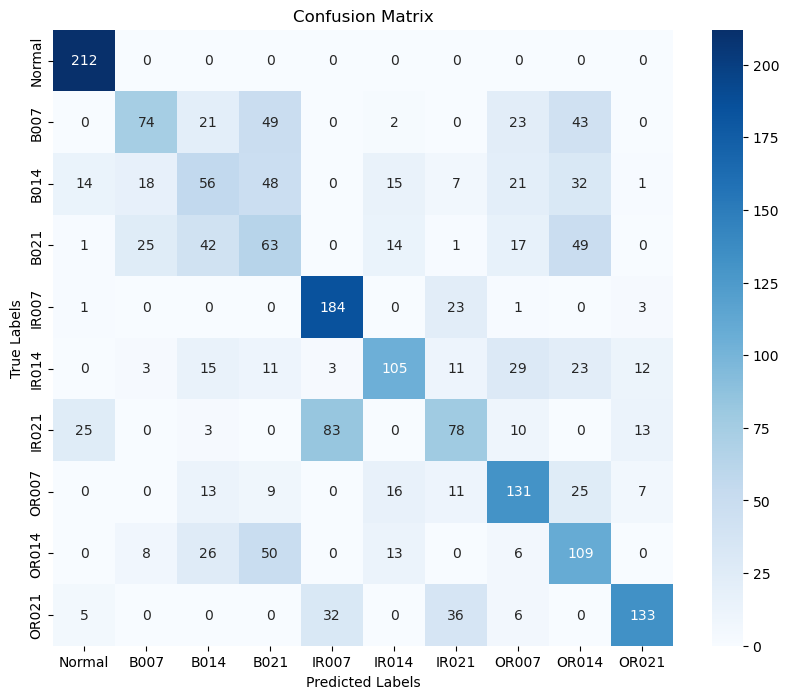


Đang vẽ t-SNE (có thể mất một chút thời gian)...
Trích xuất được 2120 features với 320 chiều.


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\Admin\AppData\Local\Temp\ipykernel_18684\767722820.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=all_labels, cmap=plt.cm.get_cmap("jet", NUM_CLASSES), alpha=0.7)


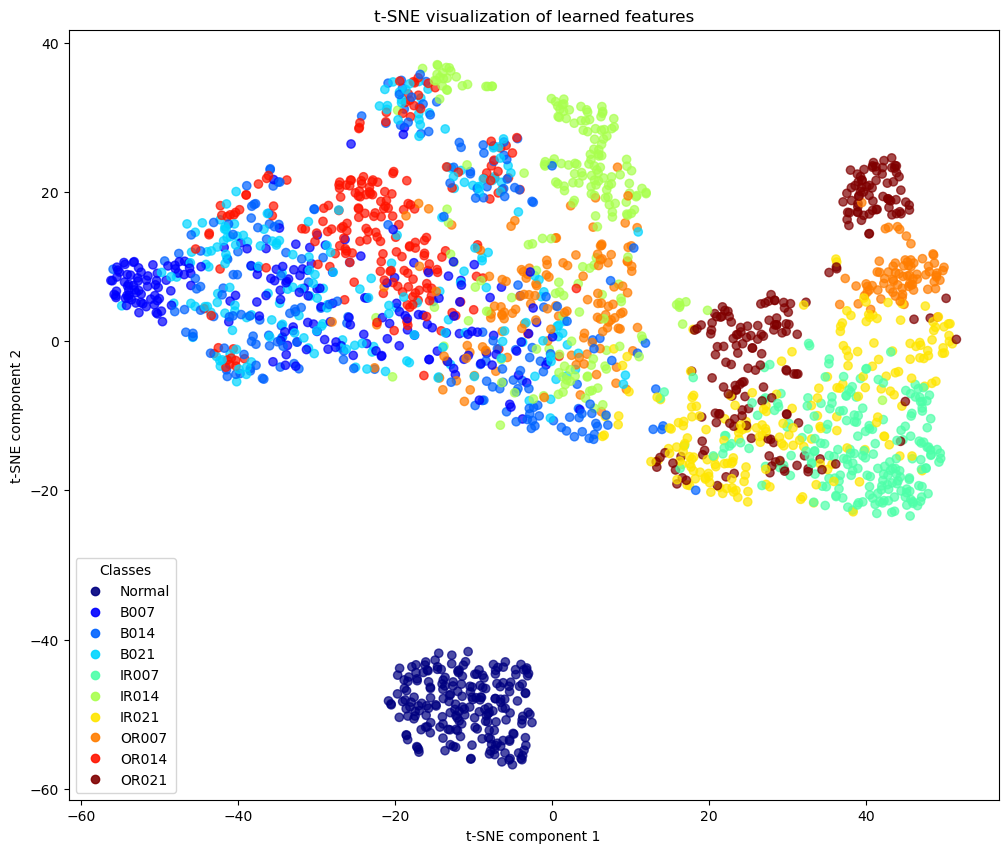

In [ ]:
# 1. Chuẩn bị
# Định nghĩa tên các lớp (có thể tùy chỉnh cho phù hợp hơn)
fault_dict_simple = {
    0 : 'Normal', 1 : 'B007', 2 : 'B014', 3 : 'B021',
    4 : 'IR007', 5 : 'IR014', 6 : 'IR021',
    7 : 'OR007', 8 : 'OR014', 9 : 'OR021'
}
class_names = [fault_dict_simple[i] for i in range(NUM_CLASSES)]

# Load mô hình đã huấn luyện (nếu cần)
# Nếu bạn đã có biến `trained_model` từ hàm train_model, bạn có thể dùng nó trực tiếp.
# Nếu không, load từ file:
model_to_visualize = PaperModel(NUM_CLASSES) # Khởi tạo kiến trúc
model_to_visualize.load_state_dict(torch.load('srepcnn_t_best_model.pth', map_location=DEVICE))
model_to_visualize.to(DEVICE)
model_to_visualize.eval() # Chuyển sang chế độ đánh giá

# 2. Hàm vẽ Confusion Matrix
def plot_confusion_matrix(model, dataloader, device, class_names_list):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names_list, yticklabels=class_names_list)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# 3. Hàm vẽ t-SNE
def plot_tsne(model, dataloader, device, class_names_list, n_iter=1000, perplexity=30.0):
    model.eval()
    all_features = []
    all_labels = []

    # Tạo một hook để lấy output của lớp trước lớp fully connected
    # Trong PaperModel, đó là output của self.avgpool sau khi flatten
    features_from_hook = []
    def hook_fn(module, input, output):
        # output ở đây là sau self.avgpool, có shape (batch_size, channels, 1, 1)
        # cần flatten nó thành (batch_size, channels)
        flattened_output = torch.flatten(output, 1)
        features_from_hook.append(flattened_output.detach().cpu().numpy())

    # Đăng ký hook vào lớp self.avgpool
    # Lưu ý: Nếu bạn thay đổi kiến trúc, bạn có thể cần thay đổi lớp để hook
    hook_handle = model.avgpool.register_forward_hook(hook_fn)

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            # Chạy forward pass để hook được kích hoạt và features_from_hook được cập nhật
            _ = model(inputs)
            all_labels.extend(labels.cpu().numpy())

    hook_handle.remove() # Gỡ hook sau khi đã lấy xong features

    # Nối các batch features lại
    if features_from_hook:
        all_features = np.concatenate(features_from_hook, axis=0)
    else:
        print("Không có features nào được trích xuất. Kiểm tra lại hook hoặc dataloader.")
        return

    if len(all_features) == 0:
        print("Mảng features rỗng.")
        return

    print(f"Trích xuất được {all_features.shape[0]} features với {all_features.shape[1]} chiều.")

    # Giảm chiều bằng t-SNE
    tsne = TSNE(n_components=2, random_state=42, n_iter=n_iter, perplexity=perplexity, n_jobs=-1)
    tsne_results = tsne.fit_transform(all_features)

    # Vẽ
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=all_labels, cmap=plt.cm.get_cmap("jet", NUM_CLASSES), alpha=0.7)
    plt.title('t-SNE visualization of learned features')
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')

    # Tạo legend
    handles, _ = scatter.legend_elements(prop="colors", alpha=0.9)
    if len(handles) == len(class_names_list):
         plt.legend(handles, class_names_list, title="Classes")
    else: # Trường hợp số lượng unique labels trong batch nhỏ hơn NUM_CLASSES
        unique_labels_in_data = sorted(list(set(all_labels)))
        filtered_class_names = [class_names_list[i] for i in unique_labels_in_data]
        if len(handles) == len(filtered_class_names):
            plt.legend(handles, filtered_class_names, title="Classes")
        else:
            print(f"Không thể tạo legend chính xác. Số lượng handles: {len(handles)}, số lượng class_names: {len(class_names_list)}, số lượng unique labels: {len(unique_labels_in_data)}")


    plt.show()


# --- Gọi các hàm visualize ---
print("Đang vẽ Confusion Matrix...")
# Sử dụng val_loader để visualize
plot_confusion_matrix(model_to_visualize, val_loader, DEVICE, class_names)

print("\nĐang vẽ t-SNE (có thể mất một chút thời gian)...")
# Sử dụng val_loader để visualize.
# Bạn có thể giảm số lượng mẫu nếu val_loader quá lớn để t-SNE chạy nhanh hơn
# bằng cách tạo một dataloader mới với một subset của val_dataset.
# Ví dụ:
# from torch.utils.data import Subset
# subset_indices = np.random.choice(len(val_dataset), size=min(1000, len(val_dataset)), replace=False)
# tsne_dataset = Subset(val_dataset, subset_indices)
# tsne_loader = DataLoader(tsne_dataset, batch_size=BATCH_SIZE, shuffle=False)
# plot_tsne(model_to_visualize, tsne_loader, DEVICE, class_names)

plot_tsne(model_to_visualize, val_loader, DEVICE, class_names, n_iter=1000, perplexity=30) # n_iter và perplexity có thể cần điều chỉnh